In [1]:
!pip install torch==2.7.0 torchvision==0.22.0 pycocotools


  Using cached pycocotools-2.0.8-cp312-cp312-win_amd64.whl.metadata (1.1 kB)
Using cached pycocotools-2.0.8-cp312-cp312-win_amd64.whl (83 kB)



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor 

In [3]:
import os
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
import json
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO

class CocoDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.img_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

         
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            boxes.append([
                float(bbox[0]),
                float(bbox[1]),
                float(bbox[0] + bbox[2]),
                float(bbox[1] + bbox[3])
            ])
            labels.append(ann['category_id'])

          
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        image_id = torch.tensor([idx])

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


In [5]:
# Define the transformation
transform = T.Compose([T.ToTensor()])

# Path to COCO dataset
root_dir = r"C:\Users\chiraag\Downloads\COCO 128.v2-640x640.coco\train"  # Update this path accordingly
annotation_file = r"C:\Users\chiraag\Downloads\COCO 128.v2-640x640.coco\train\_annotations.coco.json"  
train_dataset = CocoDataset(root_dir=root_dir, annotation_file=annotation_file, transforms=transform)
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Validation Dataset (same folder structure as train but with validation data)
validate_root_dir = r"C:\Users\chiraag\Downloads\COCO 128.v2-640x640.coco\valid"
validate_annotation_file = r"C:\Users\chiraag\Downloads\COCO 128.v2-640x640.coco\valid\_annotations.coco.json"

validate_dataset = CocoDataset(root_dir=validate_root_dir, annotation_file=validate_annotation_file, transforms=transform)
validate_data_loader = DataLoader(validate_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:

num_classes = 91  
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


c:\Users\chiraag\Desktop\venv10\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chiraag\Desktop\venv10\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


In [8]:
model.train()
for epoch in range(10):
    for images, targets in train_data_loader:
        # Ensure each image is a tensor of shape [3, H, W]
        if isinstance(images, torch.Tensor):
            # If images is a single tensor of shape [B, C, H, W], convert it to list of [C, H, W]
            images = [img.to(device) for img in images]
        else:
            # If images is already a list of [C, H, W]
            images = [img.to(device) for img in images]

        # Ensure targets is a list of dictionaries with tensor values on the correct device
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)

        # Sum all the losses
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/10], Loss: {losses.item():.4f}")


Epoch [1/10], Loss: 5.3144
Epoch [1/10], Loss: 3.5684
Epoch [1/10], Loss: 2.0789
Epoch [1/10], Loss: 3.6727
Epoch [1/10], Loss: 1.0435
Epoch [1/10], Loss: 1.6034
Epoch [1/10], Loss: 1.3481
Epoch [1/10], Loss: 2.3584
Epoch [1/10], Loss: 1.1392
Epoch [1/10], Loss: 1.3066
Epoch [1/10], Loss: 2.7787
Epoch [1/10], Loss: 3.0738
Epoch [1/10], Loss: 1.3036
Epoch [1/10], Loss: 1.3717
Epoch [1/10], Loss: 0.5677
Epoch [1/10], Loss: 0.5760
Epoch [1/10], Loss: 1.8940
Epoch [1/10], Loss: 0.5577
Epoch [1/10], Loss: 1.5523
Epoch [1/10], Loss: 0.9295
Epoch [1/10], Loss: 1.0262
Epoch [1/10], Loss: 0.6921
Epoch [1/10], Loss: 0.6258
Epoch [1/10], Loss: 2.4001
Epoch [1/10], Loss: 0.9814
Epoch [1/10], Loss: 0.6244
Epoch [1/10], Loss: 0.7186
Epoch [1/10], Loss: 0.8076
Epoch [1/10], Loss: 2.2400
Epoch [1/10], Loss: 0.6594
Epoch [1/10], Loss: 3.0270
Epoch [1/10], Loss: 3.0092
Epoch [1/10], Loss: 0.8913
Epoch [1/10], Loss: 1.3919
Epoch [1/10], Loss: 1.1291
Epoch [1/10], Loss: 1.3408
Epoch [1/10], Loss: 1.2138
E

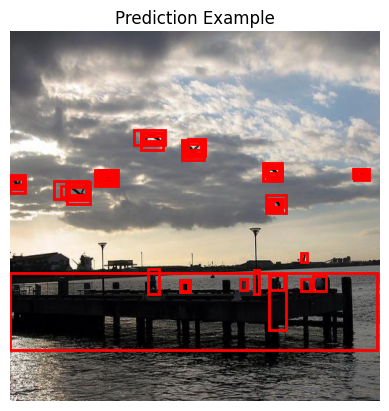

In [10]:
# Inference on Validation Set
model.eval()
with torch.no_grad():
    for images, targets in validate_data_loader:
        images = [img.to(device) for img in images]
        predictions = model(images)

        # Display results for the first image in the batch
        pred = predictions[0]
        img = images[0].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        for box in pred['boxes']:
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2))
        plt.title("Prediction Example")
        plt.axis('off')
        plt.show()
        break  # Stop after one batch for demo purposes
